# Objekttracking nach Lakshmanan und Smith (2009)

In ihrem Artikel "An Objective Method of Evaluating and Devising Storm-Tracking Algorithms" präsentieren Lakshmanan und Smith einen interessanten Ansatz für die Verfolung von Gewitterzellen. Dieser Ansatz setzt allerdings eine Objektdefinition voraus. Aber vielleicht kann man ein paar Punkte dieses Ansatzes adaptieren.

Die Schritte sind wie folgt:

1. Erkannte Gewitterzellen werden von Zeitschritt _t_<sub>n-1</sub> in den Zeitschritt _t_<sub>n</sub> projiziert.
2. Die Gewitterzellen im Zeitschritt _t_<sub>n</sub> werden nach Trajektorienlänge sortiert, um eventuelle Zellteilungen und -verschmelzungen richtig zuordnen zu können.
3. Für jeden (unzugewiesenen) Objektschwerpunkt alle anderen Schwerpunkte finden, die zu _t_<sub>n</sub> innerhalb des Radius _d_<sub>n-1</sub>&thinsp;km um einen projizierten Schwerpunkt liegen.
4. Wenn nur ein Schwerpunkt innerhalb des Suchradius liegt, und der Abstand zwischen ihm und dem projizierten Schwerpunkt &le; 5&thinsp;km ist, beide Gewitterzellen verbinden.
5. Schritte 3 und 4 wiederholen, bis keine Änderung mehr erfolgt. Damit wurden alle eindeutigen Schwerpunkte zugeordnet. Nun kann es allerdings vorkommen, dass auch mehrere Schwerpunkte innerhalb des Radius liegen. Um diese richtig zuzuordnen, sind noch ein paar Schritte nötig.

6. Eine Kostenfunktion _c<sub>i,j</sub>_ für die Zuweisung der Kandidatenzelle *i* bei _t_<sub>n</sub> zur einer von  _t_<sub>n-1</sub> projizierten Zelle *j*, definieren:
$$c_{i,j} = (x_i - x_j)^2 + (y_i - y_j)^2 + \frac{A_i}{\pi} \left ( \frac{\left|A_i - A_j\right|}{\mathrm{max}(A_i,A_j)} + \frac{\left|d_i - d_j \right|}{\mathrm{max}(d_i,d_j)} \right)$$
mit: 
  * _x_, _y_ : Schwerpunktkoordinaten  der Zellen
  * _d_     : Intensitätsextremwert der Zellen
  * _A_     : Zellfläche
  * |_a_|     : Betrag von _a_
  * max(_a_,_b_): Maximum von _a_ und _b_
 
7. Jeden noch unzugewiesenen Schwerpunkt bei _t_<sub>n</sub> innerhalb eines Radius _d_<sub>n</sub> identifizieren, wobei $d_\mathrm{n} = \sqrt{\frac{A}{\pi}}$.
8. Jedem noch unzugewiesenen Schwerpunkt bei _t_<sub>n</sub> demjenigen Schwerpunkt innerhalb von _d_<sub>n</sub> zuweisen, für den die Kostenfunktion _c_ minimal wird. Wenn es innerhlab dieses Suchradius keinen weiteren Schwerpunkt gibt, den Schwerpunkt als neue Zelle markieren.

Dann probieren wir das doch mal aus.

## 0. Pakete laden und Vorbereitung der Daten

In [9]:
%matplotlib inline
import sys
sys.path.append("/vols/talos/home/stephan/utils")
import load_satellite_data as lsd

sys.path.append("/vols/talos/home/stephan/utils/tracking")
import optical_flow_tracking as oft

import numpy as np
import pandas as pd
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
import matplotlib as mpl

import skimage.morphology as mor

import xarray as xr

Zuerst definieren wir uns eine Reihe von Zeitschritten.

In [2]:
t_steps = pd.date_range(start='20130618T1100',end='20130618T1200',freq='5min')

Als nächstes laden wir uns SEVIRI-Daten für die Zeitschritte.

In [3]:
#sat_data = np.array([lsd.load_satellite_data(t,channel='HRV',region='germ') for t in t_steps])
sat_data = np.array([lsd.load_satellite_data(t,channel='IR_108',region='germ') for t in t_steps])

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


Text(0.5,1,u'IR-10,8-\xb5m-Kanal, 2013-06-18 11:00:00')

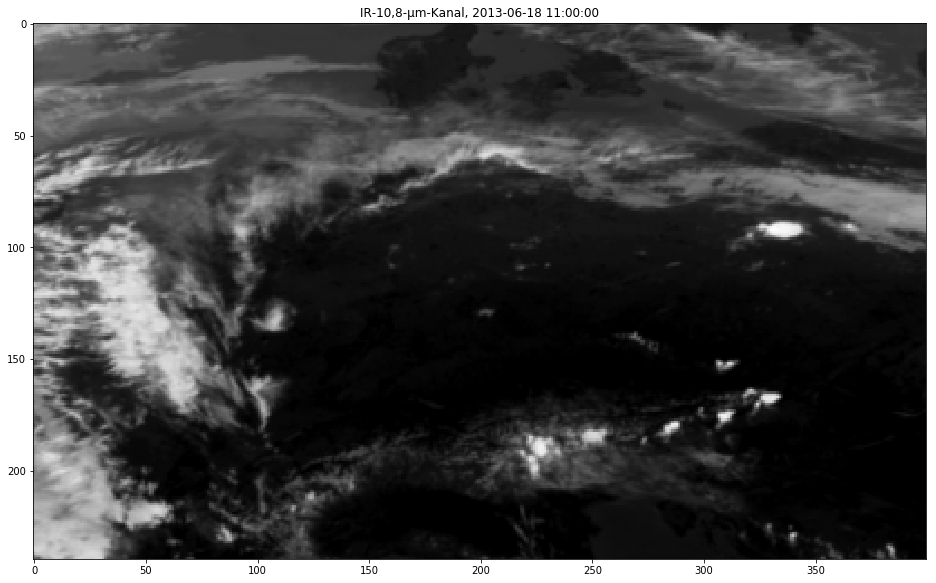

In [5]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(sat_data[0],vmin=210,vmax=300,cmap='gray_r')
ax.set_title(u'IR-10,8-µm-Kanal, {}'.format(t_steps[0]))

Als einfache Segmentierung setzten wir einen festen Schwellwert und führen dann eine Nächste-Nachbar-Markierung durch.

In [6]:
sat_data_masked = np.array([~np.ma.masked_greater(d,265).mask*1 for d in sat_data])

In [7]:
sat_data_labeled = np.array([ndi.label(d)[0] for d in sat_data_masked])

Um die Flächen der Objekte richtig berechnen zu können, brauchen wir auch die Pixeldimensionen.

In [11]:
pixel_dim = xr.open_dataset("/vols/talos/home/stephan/data/SEVIRI/auxdata/msg_rss_eu_pixel_sizes.nc")

In [ ]:
(156, 756), (1356, 2156)

In [13]:
pixel_dim

<xarray.Dataset>
Dimensions:                (x: 600, y: 800)
Coordinates:
    lat                    (x, y) float32 64.80305 64.78816 64.77441 ...
    lon                    (x, y) float32 -28.561222 -28.441475 -28.32434 ...
Dimensions without coordinates: x, y
Data variables:
    col_distance_backward  (x, y) float64 4.671 4.671 4.629 4.641 4.623 ...
    col_distance_forward   (x, y) float64 4.671 4.629 4.641 4.623 4.613 ...
    row_distance_forward   (x, y) float64 13.37 13.34 13.28 13.28 13.25 ...
    row_distance_backward  (x, y) float64 13.37 13.34 13.28 13.28 13.25 ...
    mean_row_distance      (x, y) float64 13.37 13.34 13.28 13.28 13.25 ...
    mean_col_distance      (x, y) float64 4.671 4.65 4.635 4.632 4.618 4.6 ...
Attributes:
    title:    Pixel sizes of the MSG RSS eu domain

In [27]:
row_dist = pixel_dim.mean_row_distance.data[60:300, 320:720]
col_dist = pixel_dim.mean_col_distance.data[60:300, 320:720]

In [20]:
row_dist.shape

(240, 400)

In [39]:
def object_area(row_dist,col_dist,locations):
    area = []
    for i in xrange(len(locations[0])):
        area.append(row_dist[locations[0][i],locations[1][i]]*col_dist[locations[0][i],locations[1][i]])
        
    area = np.array(area)
    
    return np.sum(area)

## 1. Schritt 

Wir ermitteln die Zentroide der "Zellen" im ersten Zeitschritt und projizieren diese in den zweiten Zeitschritt.

In [23]:
centroids_t0 = ndi.measurements.center_of_mass(sat_data_masked[0],
                                               sat_data_labeled[0],
                                               np.unique(sat_data_labeled[0])[1:])

Wie müssen auch die Trajektorien irgendwie verfolgen. Deshalb wäre es vielleicht eine gute Idee ihre Position einige benötigte Zelleigenschaften zu speichern.

In [35]:
tracks = {"{}_{}".format(t_steps[0].strftime("%Y%m%dT%H%M"),tr_id):
          {'col':[],'row':[],'area':[],'min':[],'time':[],'track_length':0} for tr_id in np.unique(sat_data_labeled[0])[1:]}

In [40]:
for i in np.unique(sat_data_labeled[0])[1:-1]:
    locations = np.where(sat_data_labeled[0]==i)
    tr_id = "{}_{}".format(t_steps[0].strftime("%Y%m%dT%H%M"),i)
    tracks[tr_id]['col'].append(centroids_t0[i][0])
    tracks[tr_id]['row'].append(centroids_t0[i][1])
    #tracks[tr_id]['max'] = sat_data[0][locations].max()
    tracks[tr_id]['min'].append(sat_data[0][locations].min())
    tracks[tr_id]['area'].append(object_area(row_dist,col_dist,locations))
    tracks[tr_id]['time'].append(t_steps[0])
    tracks[tr_id]['track_length'] += 1

In [41]:
tracks

{'20130618T1100_1': {'area': [8453.495773951523],
  'col': [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
  'min': [236.5529456762966, 236.5529456762966, 236.5529456762966],
  'row': [49.833333333333336, 49.833333333333336, 49.833333333333336],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_10': {'area': [277.0454616183415],
  'col': [12.0],
  'min': [259.7158597608433],
  'row': [39.5],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_100': {'area': [748.3519235689892],
  'col': [169.52631578947367],
  'min': [217.18465734787338],
  'row': [21.526315789473685],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_101': {'area': [338.71432659984566],
  'col': [169.5],
  'min': [244.68612538817948],
  'row': [77.0],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_102': {'area': [35.3615362346

Für die Projektion brauchen wir ein Advektionsfeld. Das können wir mittels optischem Fluss bestimmen.

In [42]:
flow = oft.calculate_optical_flow([sat_data[0],sat_data[1]],'tvl1',True)

Als nächstes verschieben wir alle Zentroide.

In [46]:
centroids_t01 = []
centroid_map_t01 = np.zeros_like(sat_data[0],dtype="int16")

for i,c in enumerate(centroids_t0):
    c_irow = int(np.rint(c[0]))
    c_icol = int(np.rint(c[1]))
    shift_col = flow[0][...,0][c_irow,c_icol]
    shift_row = flow[0][...,1][c_irow,c_icol]
    
    c_new = c[0] + shift_col
    r_new = c[1] + shift_row
    
    ci_new = int(np.rint(c_new))
    ri_new = int(np.rint(r_new))
    
    print i, ci_new, ri_new
    centroids_t01.append((c_new,r_new))
    centroid_map_t01[ci_new,ri_new] = i+1


0 6 17
1 2 49
2 2 55
3 2 59
4 2 218
5 2 221
6 16 320
7 8 43
8 7 57
9 12 50
10 14 39
11 14 44
12 15 365
13 17 360
14 16 34
15 25 87
16 21 135
17 33 358
18 25 288
19 26 299
20 27 300
21 39 15
22 29 305
23 29 375
24 34 89
25 35 109
26 35 125
27 36 66
28 37 132
29 42 57
30 40 118
31 40 347
32 41 49
33 41 115
34 44 164
35 47 391
36 45 176
37 61 195
38 52 134
39 67 30
40 54 137
41 58 44
42 58 63
43 58 67
44 58 280
45 60 61
46 59 124
47 65 2
48 61 147
49 62 35
50 63 65
51 65 241
52 66 240
53 80 358
54 70 251
55 83 100
56 71 175
57 73 170
58 75 310
59 75 307
60 76 17
61 82 153
62 80 270
63 85 35
64 84 -1
65 84 2
66 87 0
67 87 44
68 87 84
69 87 28
70 88 42
71 129 37
72 94 335
73 93 21
74 94 103
75 96 321
76 97 372
77 107 95
78 119 70
79 112 93
80 119 96
81 127 70
82 128 82
83 131 91
84 133 107
85 134 86
86 136 87
87 137 72
88 137 91
89 138 88
90 140 269
91 144 19
92 153 309
93 208 18
94 166 101
95 164 90
96 161 42
97 164 46
98 165 320
99 168 328
100 170 21
101 170 77
102 172 84
103 173 85
104 1

In [44]:
cmap = mpl.cm.get_cmap('nipy_spectral')
norm0 = mpl.colors.Normalize(vmin=0, vmax=np.max(sat_data_labeled[0]))
norm1 = mpl.colors.Normalize(vmin=0, vmax=np.max(sat_data_labeled[1]))

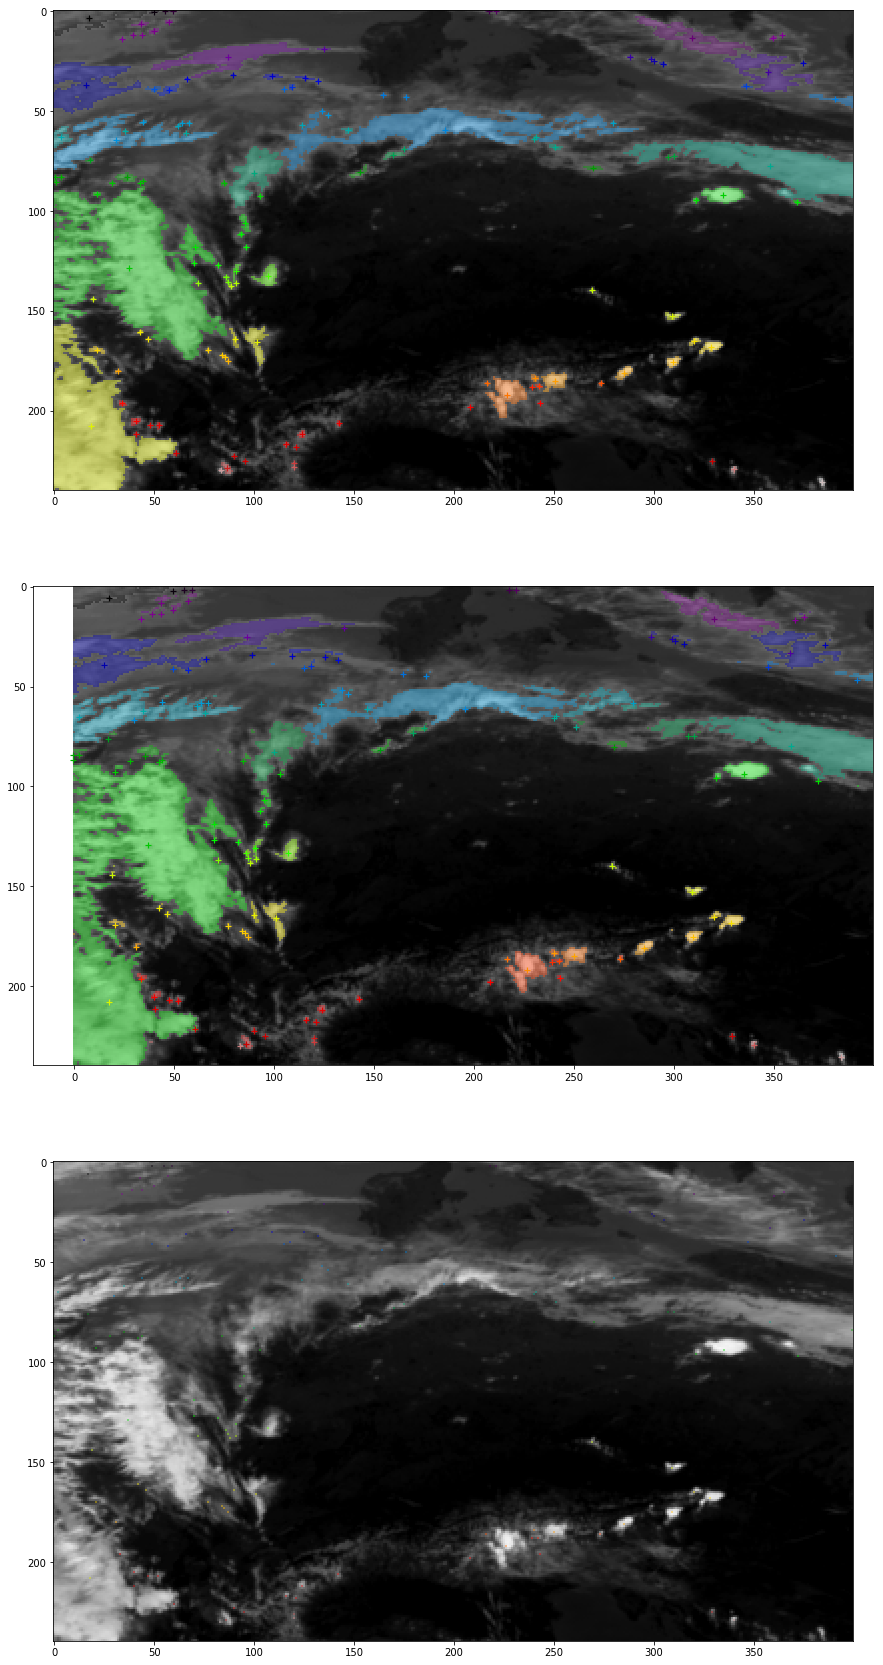

In [45]:
fig,ax = plt.subplots(3,1,figsize=(16,30))
ax[0].imshow(sat_data[0],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(sat_data_labeled[0],1),cmap='nipy_spectral',alpha=0.4)
for i,c in enumerate(centroids_t0):
    ax[0].plot(c[1],c[0],marker='+',markersize=6,mew=1.2,color=cmap(norm0(i)))
    
ax[1].imshow(sat_data[1],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(sat_data_labeled[1],1),cmap='nipy_spectral',alpha=0.4)
for i,c in enumerate(centroids_t01):
    ax[1].plot(c[1],c[0],marker='+',markersize=6,mew=1.2,color=cmap(norm1(i)))
    
ax[2].imshow(sat_data[1],vmin=210,vmax=300,cmap='gray_r')
ax[2].imshow(np.ma.masked_less(centroid_map_t01,1),cmap='nipy_spectral',alpha=0.4)

## Schritt 2

Nun müssten wir die vorhandenen Tracks nach Trajektorielänge sortieren, da wir bisher nur einen Zeitschritt haben erübrigt sich das. Aber prinzipiell könnte man aus dem "tracks"-Dictionary einfach z.B. die Länge der Zeitschritte ermitteln.

## Schritt 3
In diesem Schritt überprüfen wir, ob Schwerpunkte des aktuellen Zeitschritts in einem Umkreis um die projizierten Schwerpunkte aus dem vorherigen Zeitschritt liegen.

Dafür bestimmen wir erstmal die Schwerpunkte der "Zellen" des aktuellen Zeitschritts.

In [48]:
centroids_t1 = ndi.measurements.center_of_mass(sat_data_masked[1],
                                               sat_data_labeled[1],
                                               np.unique(sat_data_labeled[1])[1:])

Als nächstes erzeugen wir die Umkreise um die projizieren Schwerpunkte des vorherigen Zeitschritts.

In [49]:
def circle_radius_int(area):
    return(int(np.ceil(np.sqrt(area/np.pi))))

In [50]:
np.where(centroid_map_t01==42)

(array([58]), array([44]))

In [51]:
np.unique(centroid_map_t01)[1:]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136], dtype=int16)

In [74]:
t_prev = t_steps[0].strftime("%Y%m%dT%H%M")
centroid_map_t01_dilated = centroid_map_t01.copy()

for i in np.unique(centroid_map_t01)[1:]:
    tid = "{}_{}".format(t_prev,i)

    ci,ri = np.where(centroid_map_t01==i)
    ci = ci[0]
    ri = ri[0]
    
    area = tracks[tid]['area']
    
    if area>=80: # Kriterium aus dem Paper r <= 5 km
        area=80

    r_col = int(np.ceil(circle_radius_int(area) / 3.2))
    r_row = int(np.ceil(r_col/6.1))

    row_coords = np.arange(np.clip(ri-r_row,0,ri),
                           np.clip(ri+r_row+1,ri,sat_data[0].shape[0])).astype("uint8")

    col_coords = np.arange(np.clip(ci-r_col,0,ci),
                           np.clip(ci+r_col+1,ci,sat_data[0].shape[1])).astype("uint8")

    for rc in row_coords:
        for cc in col_coords:
            centroid_map_t01_dilated[rc,cc] = i

In [73]:
np.ceil(circle_radius_int(area) / 3.2)

2.0

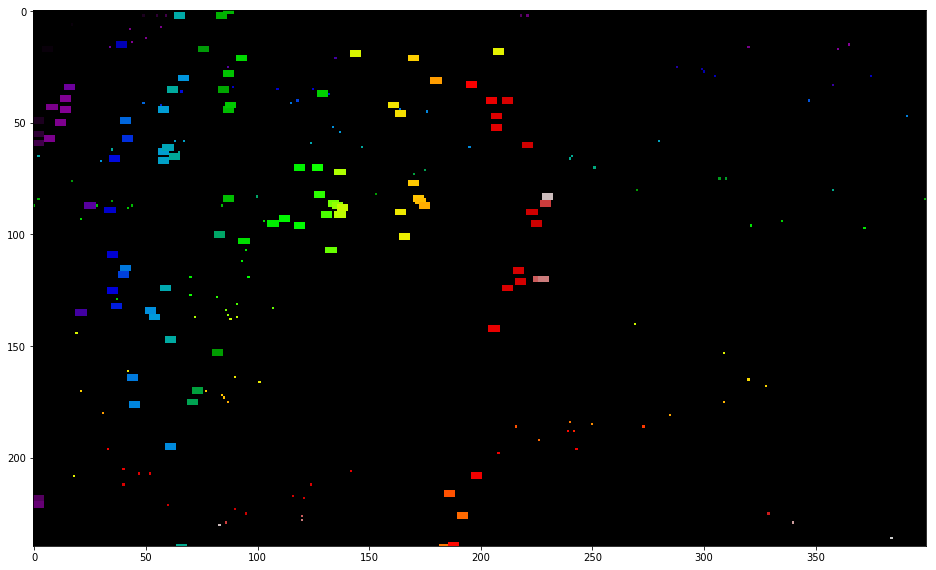

In [75]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(centroid_map_t01_dilated,cmap='nipy_spectral')

## Schritt 5
Als nächstes müssen wir überprüfen, welche Zentroide des neuen Zeitschrittes innerhalb den Bereichen liegen.

In [76]:
centroid_map_t1 = np.zeros_like(sat_data[0],dtype='int16')

for i,c in enumerate(centroids_t1):
    if i ==0:
        continue
    else:
        ci = int(np.rint(c[1]))
        ri = int(np.rint(c[0]))

        centroid_map_t1[ri,ci] = i

In [77]:
cm01 = np.zeros_like(centroid_map_t01_dilated)
cm1 = np.zeros_like(centroid_map_t1)

In [78]:
cm01[np.where(centroid_map_t01_dilated>0)] = 1
cm1[np.where(centroid_map_t1>0)] = 1

In [79]:
fortsetzung = cm01 & cm1

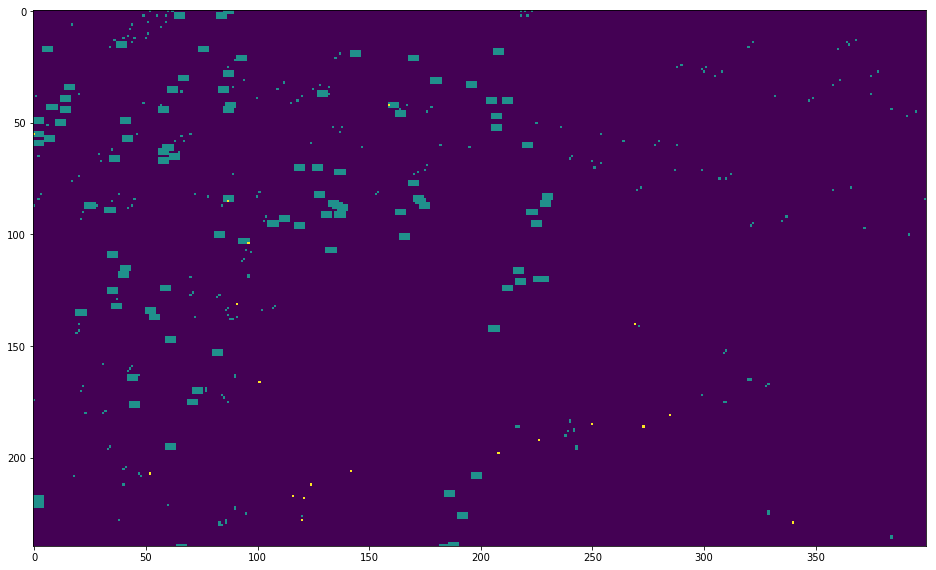

In [80]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(cm01 + cm1)

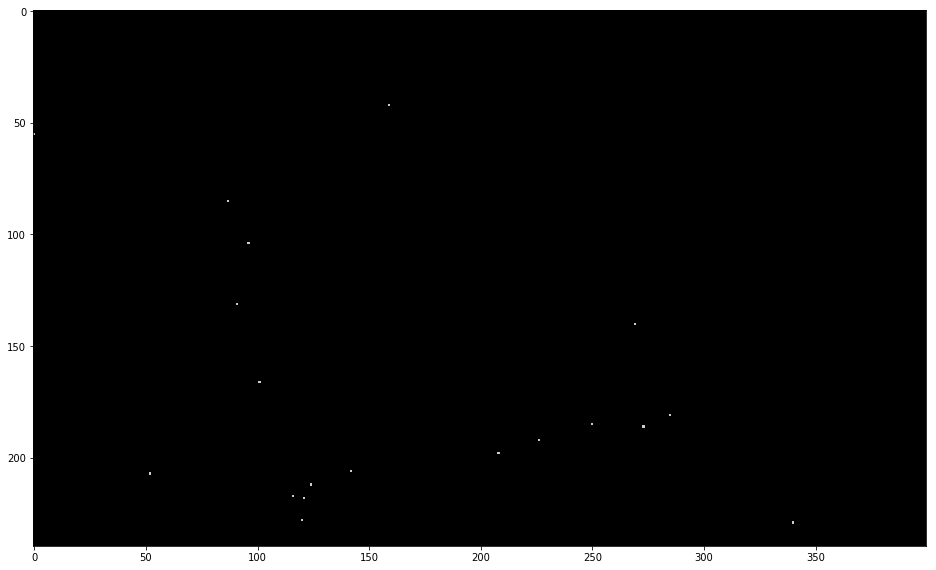

In [81]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(fortsetzung,cmap='nipy_spectral')

Das sind die Fortsetzungen der vorherigen Tracks.

In [82]:
fortsetzung_mask = np.ma.masked_less(fortsetzung,1)

In [83]:
nur_einzeln = centroid_map_t01_dilated | centroid_map_t1

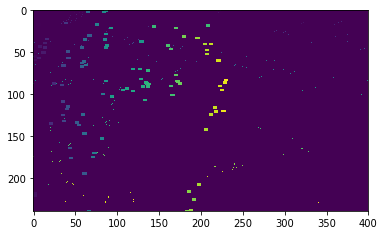

In [84]:
plt.imshow(nur_einzeln)

In [85]:
nur_t1 = nur_einzeln & centroid_map_t1

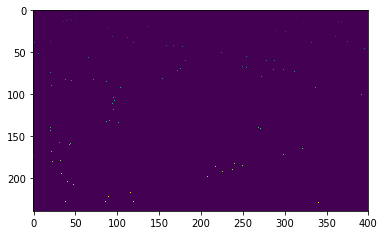

In [86]:
plt.imshow(nur_t1)

In [90]:
old_cells = np.ma.masked_where(fortsetzung_mask==False,centroid_map_t01_dilated)

In [94]:
new_cells = np.ma.masked_where(fortsetzung_mask==False,centroid_map_t1)

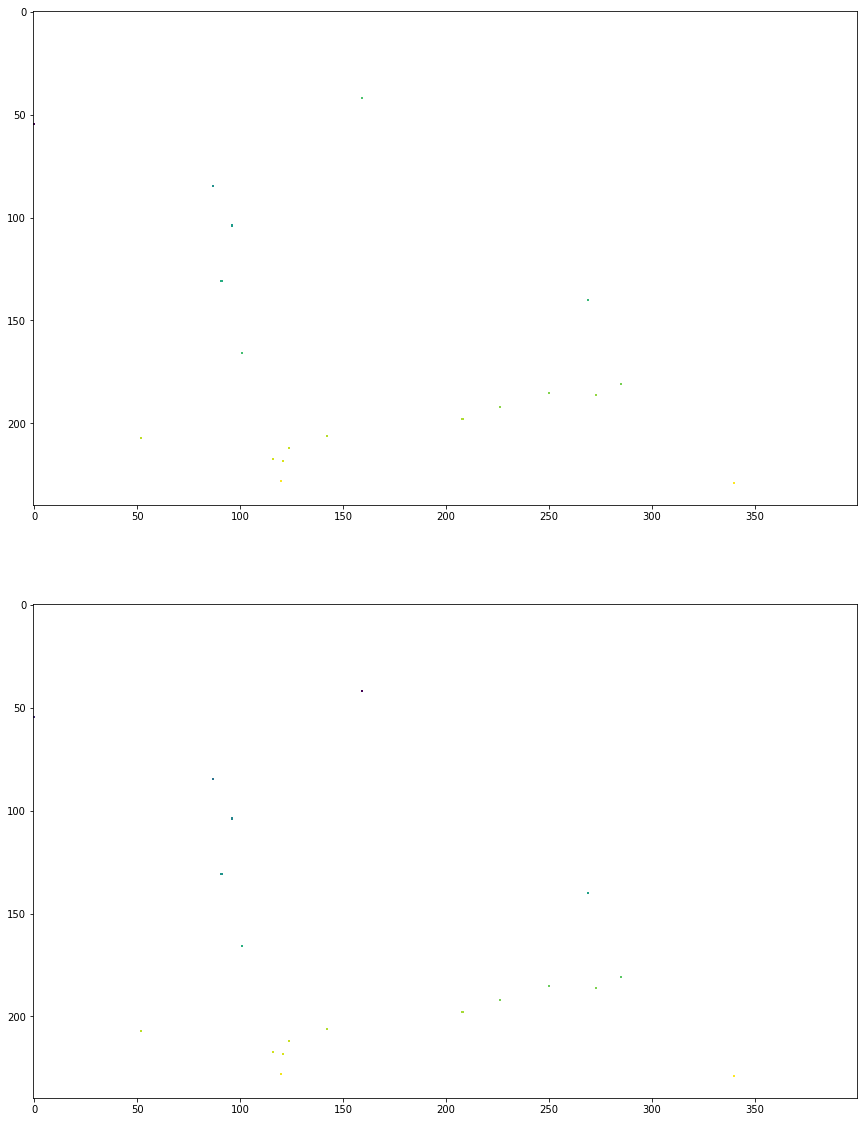

In [96]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].imshow(old_cells)
ax[1].imshow(new_cells)

In [97]:
print np.unique(old_cells).data
print np.unique(new_cells).data

[  3  69  75  84  91  95  97 107 109 111 113 118 120 121 123 125 126 133
 134   0]
[ 36  49  73  80  86  91  97 108 111 113 114 120 122 123 125 126 127 131
 133   0]


In [98]:
cell_connections = {c:[] for c in np.unique(old_cells).data}

for cell_id in np.unique(old_cells).data:
    if cell_id == 0:
        continue
    else:
        cell_points = np.where(old_cells==cell_id)

        new_cell = np.unique(new_cells[cell_points]).data
        
        for nc in new_cell:
            cell_connections[cell_id].append(nc)

In [99]:
cell_connections

{0: [],
 3: [49],
 69: [73],
 75: [80],
 84: [86],
 91: [91],
 95: [97],
 97: [36],
 107: [108],
 109: [111],
 111: [113],
 113: [114],
 118: [120],
 120: [122],
 121: [123],
 123: [125],
 125: [126],
 126: [127],
 133: [131],
 134: [133]}

Da hier alle Zellen nur eine Fortsetzung haben, können wir einfach deren Eigenschaften bestimmen und an das Dictionary anhängen.

In [100]:
for cell in cell_connections:
    if cell == 0:
        continue
    else:
        tid = "{}_{}".format(t_prev,cell)
        i = cell_connections[cell]

        locations = np.where(sat_data_labeled[1]==i)

        tracks[tid]['col'].append(centroids_t1[i[0]][0])
        tracks[tid]['row'].append(centroids_t1[i[0]][1])

        tracks[tid]['min'].append(sat_data[0][locations].min())
        tracks[tid]['area'].append(object_area(row_dist,col_dist,locations))
        tracks[tid]['time'].append(t_steps[1])
        tracks[tid]['track_length'] += 1

In [101]:
tracks

{'20130618T1100_1': {'area': [8453.495773951523],
  'col': [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
  'min': [236.5529456762966, 236.5529456762966, 236.5529456762966],
  'row': [49.833333333333336, 49.833333333333336, 49.833333333333336],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_10': {'area': [277.0454616183415],
  'col': [12.0],
  'min': [259.7158597608433],
  'row': [39.5],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_100': {'area': [748.3519235689892],
  'col': [169.52631578947367],
  'min': [217.18465734787338],
  'row': [21.526315789473685],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_101': {'area': [338.71432659984566],
  'col': [169.5],
  'min': [244.68612538817948],
  'row': [77.0],
  'time': [Timestamp('2013-06-18 11:00:00', freq='5T')],
  'track_length': 1},
 '20130618T1100_102': {'area': [35.3615362346

Wenn wir mehrere Zellen hätten, müssten wir anders vorgehen.

## Schritt 6
Um zu entscheiden welcher von mehreren Schwerpunkten eine geeignete Fortsetzung ist, wird im Artikel eine Kostenfunktion definiert.

In [88]:
def cost_function(row_prev,row_next,col_prev,col_next,area_prev,area_next,intensity_prev,intensity_next,
                  extreme='min'):
    
    location_term = (col_next - col_prev)**2 + (row_next - row_prev)**2
    area_term = np.abs(area_next - area_prev) / float(max(area_next,area_prev))
    
       
    if extreme == 'min':
        intensity_term = np.abs(intensity_next - intensity_prev) / float(min(intensity_next,intensity_prev))
    elif extreme == 'max':
        intensity_term = np.abs(intensity_next - intensity_prev) / float(max(intensity_next,intensity_prev))
    else:
        return
    #print("Location term = {},\narea term = {},\nintensity term = {}".format(location_term,area_term,intensity_term))
    return location_term + area_next/np.pi * (area_term + intensity_term)   

In [92]:
cost_function(10,12,9,8,100,120,260,255,'min')

12.115162161755322

In [93]:
cost_function(10,12,9,12,100,120,260,255,'min')

20.115162161755322

## Schritt 7
Als nächstes durchlaufen wir alle Zellen mit mehreren Fortsetzungen und berechnen die Kostenfunktionen der möglichen Kandidaten, die innerhalb des Bereiches _d_<sub>n</sub> liegen. Der Kandidat mit dem kleinsten Wert ist die wahrscheinlichste Fortsetzung.

## Schritt 8
Kandidaten außerhab des Bereiches sind neue Zellen.